# Volume estimation tools

Presenting three tools for the estimation of solvent system volume using MDTraj:
 1. Grid counting, using spherical smoothing of atoms.
 2. Monte Carlo, with random uniform sampling of points.
 3. Grid counting with numpy's own 3D histogram. Incomplete.

In [1]:
# Importing everything.
import warnings
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')
from mdtraj.geometry.sasa import _ATOMIC_RADII
_ATOMIC_RADII['Cl'] = 0.175

%matplotlib inline

from datetime import datetime

In [2]:
# Loading an example trajectory:
traj = md.load('10v_restarted_trajectory.dcd',top="10v_final.pdb")

/Users/rossg/miniconda2/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/Users/rossg/miniconda2/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


## Total volume of atoms in a molecule
Useful for calculating the packing efficiency of a nanoparticle.

In [3]:
def ResidueVolume(traj,resname):
    '''
    Calculate the volume of the atomic constituents for residues in a trajectory.
    
    Parameters
    ----------
    traj  : mdtraj trajectory object
      Trajectory containing the residue of interest
    resname : string 
      the name of the residue

    Returns
    -------
    residue_vol : float
      the vdW volume of a single residue in nm^3
    totoal_vol : float
      the total volume of all matching residues in nm^3
    """
    
    
    '''
    residues = [res for res in traj.topology.residues if res.name==resname]
    if len(residues) == 0:
        print "No residues called '%s' found in trajectory."
        return
    else:
        numres = len(residues)
        
    atoms = [atm.element for atm in residues[0].atoms]
    radii = np.zeros(len(atoms))
    
    for i in range(len(atoms)):
        radii[i] = atoms[i].radius
        #print atm.symbol, radii

    residue_vol =  np.sum(np.pi*(4.0/3.0)*(radii**3))
    total_vol = residue_vol*numres
    
    return residue_vol, total_vol  

In [4]:
# Example:
trash, vol_dye = ResidueVolume(traj,'DYE')
trash, vol_mol = ResidueVolume(traj,'10V')
print vol_mol+vol_dye

73.6743866001


## Grid based calculation with spherical smoothing.

In [58]:
def init_grid(xyz,spacing,padding) :
    """
    Initialize a grid based on a list of x,y,z coordinates. Written by Sam Genheden.

    Parameters
    ----------
    xyz  : Numpy array 
      Cartesian coordinates that should be covered by the grid
    spacing : float 
      the grid spacing
    padding : float 
      the space to add to minimum extent of the coordinates

    Returns
    -------
    Numpy array
      the grid 
    list of Numpy arrays
      the edges of the grid
    """
  
    origin  = np.floor(xyz.min(axis=0))-padding
    tr      = np.ceil(xyz.max(axis=0))+padding
    length  = tr-origin
    shape  =  np.array([int(l/spacing + 0.5) + 1 for l in length],dtype=int)
    grid    = np.zeros(shape)
    edges  = [np.linspace(origin[i],tr[i],shape[i]) for i in range(3)]
    return grid,edges

def _voxel(coord,edges) :
    """
    Wrapper for the numpy digitize function to return the grid coordinates. Written by Sam Genheden.
    """
    return np.array([np.digitize(coord,edges[i])[i] for i in range(3)],dtype=int)

def _fill_sphere(coord,grid,edges,spacing,radius) :
    """
    Fill a grid using spherical smoothing

    Parameters
    ----------
    coord : Numpy array
      the Cartesian coordinates to put on the grid
    grid  : Numpy array
      the 3D grid. Will be modified
    edges : list of Numpy array
      the edges of the grid
    spacing : float 
      the grid spacing
    radius  : float 
      the radius of the smoothing
    """
    # Maximum coordinate
    maxxyz = np.minimum(coord + radius,np.array([edges[0][-1],edges[1][-1],edges[2][-1]]))
    i = 1
    # Iterate over the sphere
    rad2 = radius**2
    x = max(coord[0] - radius,edges[0][0])
    while x <= maxxyz[0] :
        y = max(coord[1] - radius,edges[1][0])
        while y <= maxxyz[1] :
            z = max(coord[2] - radius,edges[2][0])
            while z <= maxxyz[2] :
            # Check if we are on the sphere
                r2 = (x-coord[0])**2+(y-coord[1])**2+(z-coord[2])**2
                if r2 <= rad2 :
                # Increase grid with one
                    v = _voxel(np.array([x,y,z]),edges)
                    grid[v[0],v[1],v[2]] = grid[v[0],v[1],v[2]] + 1
                z = z + spacing
            y = y + spacing
        x = x + spacing
        #print x
        
    
def calc_volume(xyz,extent=0.14,spacing=0.1,verbose=False) :
    """
    Calculate the volume of a molecule using spherical smoothing

    Parameters
    ----------
    xyz : Numpy array
      the Cartesian coordinates to put on the grid
    extent  : Numpy array
      the radius applied to each atom
    spacing : float 
      the grid spacing in nanometers
      
    Returns
    -------
    volume : float
      the volume occupied by all atoms in a frame of a trajectory.
    """
    if verbose == True: print("initializing grid")
    grid,edges = init_grid(xyz,spacing,0)
    if verbose == True: print "Grid shape =",np.shape(grid)
    
    if verbose == True: print("Filling sphere")
    for coord in xyz :
        _fill_sphere(coord,grid,edges,spacing,extent)
    
    if verbose == True: print("Calculating volume")    
    volume = np.sum(grid >= 1)*(spacing**3)
    return volume

def SolvAccVol(traj, residues, frame, solvent_rad=0.14, spacing=0.05) :
    """
    Calculate the solvent accessible volume of a set of residues using spherical smoothing

    Parameters
    ----------
    traj : Mdtraj trejectory object
      the trajectory containing the residues of interest
    residues  : list or tuple of strings
      the names of the residues whose volume will be calculated
    frame : integer
      the frame from which the positions will be taken from
    solvent_rad : float 
      the radius of the solvent in nm. Arithmetic mean with residue will be used for volume calculation.
      If zero, only the vdW radii of the atoms will be used.
    spacing : float 
      the grid spacing in nanometers  
    """
    
    atmids = [atom.index for atom in traj.topology.atoms if ((atom.residue.name in residues))]
    radii = [atom.element.radius for atom in traj.topology.atoms if ((atom.residue.name in residues))]
    if solvent_rad > 0.0:
        watrads = np.repeat(solvent_rad,len(radii))
        radii = 0.5*(radii + watrads)
    
    xyz = traj.xyz[frame]
    xyz = xyz[atmids,:]
    
    grid,edges = init_grid(xyz,spacing,0)
    
    for i in range(len(atmids)):
        _fill_sphere(xyz[i],grid,edges,spacing,radii[i])
    
    volume = np.sum(grid >= 1)*(spacing**3)
    return volume

In [64]:
# Example:
print "Volume, accounting for different vdW     =", SolvAccVol(traj,("10V","DYE"),frame=0,solvent_rad=0.14)

# Using the old function, which didn't account for vdW radii:
print "Volume, not accounting for different vdW =", calc_volume(traj.xyz[0],spacing=0.05,verbose=False)

Volume, accounting for different vdW     = 35.182375
Volume, not accounting for different vdW = 35.457625


Accounting for different vdW radii doesn't have as large an effect as I expected. But as it takes the same time to compute _SolvAccVol_ is the preferred function to compute volume.

# Dependency of volume estimation on grid spacing

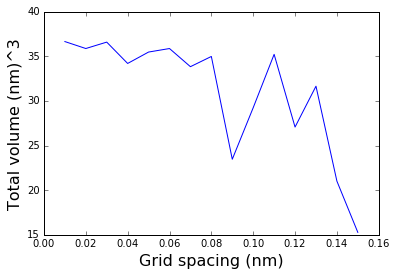

In [14]:
space = np.linspace(start=0.15,stop=0.01,num=15)
volume = np.zeros(15)

for i in range(15):
    volume[i] = calc_volume(traj.xyz[i],extent=0.14,spacing=space[i])

plt.plot(space, volume)
plt.xlabel('Grid spacing (nm)', size=16)
plt.ylabel('Total volume (nm)^3', size=16)
plt.show()   

Estimated volume _is_ dependent on the grid spacing, with volume gradually increasing as spacing is decreased. Presumably the volume levels off as spacing --> 0. Erratic estimates for spacings above 0.08 nm (= 0.8 Angstroms).

The difference between a spacing of 0.01 and 0.05 provides a lower bound for the error:

In [34]:
print "    Error = %.2f nm^3" % np.abs(volume[10] - volume[14])

    Error = 1.17 nm^3


Next, looking at how the volume of a nanoparticle changes as the simulation progresses. Choosing spacing=0.05. 

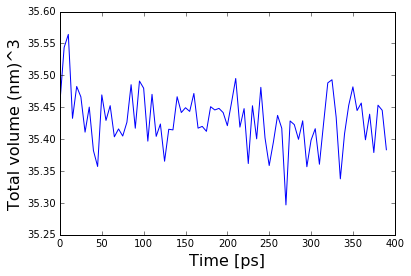

In [35]:
solvent_rad = 0.14
indices = range(0,traj.n_frames,5)
volume = np.zeros(len(indices))
for i in range(len(indices)):
    volume[i] = calc_volume(traj.xyz[i],extent=solvent_rad,spacing=0.05)
    
plt.plot(indices, volume)
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Total volume (nm)^3', size=16)
plt.show()  

Given that the error is roughly 1 nm^3, the volume is approximately constant over the trajectory.

## Monte carlo estimate of volume:

Randomly sampling points within a cube defined by the limits of the nanoparticle. Volume estimate given in nanometers.

In [36]:
def MonteCarloVolume(xyz,N,cutoff):
    """
    Function to estimate the vdw volume of molecule using Monte Carlo sampling.

    Parameters
    ----------
    xyz : Numpy array
      the Cartesian coordinates of the molecule
    N  : integer
      the number of random uniform samples to take
    cutoff : float
      the vdw radius to use as a solvent cutoff

    """    
    
    high =xyz.max(axis=0)
    low = xyz.min(axis=0)

    cube_volume =  np.prod(high-low)

    xsamps = np.random.uniform(low=low[0],high=high[0], size=N)
    ysamps = np.random.uniform(low=low[1],high=high[1], size=N)
    zsamps = np.random.uniform(low=low[2],high=high[2], size=N)
    
    samps = np.ones((N,3))
    samps[:,0] = xsamps
    samps[:,1] = ysamps
    samps[:,2] = zsamps

    dists = np.zeros(N)
    sq_cutoff = cutoff**2
    for i in range(N):
        d = ((samps[i] - xyz)**2)
        dists[i] = d.sum(axis=1).min()

    return cube_volume*np.sum(dists < sq_cutoff)/N

In [50]:
# Example:
N = 500000
startTime = datetime.now()
print MonteCarloVolume(traj.xyz[0],N,0.14)
print "Completion time = %s seconds for %i samples" % ((datetime.now() - startTime).seconds,N)

36.6651611402
Completion time = 70 seconds for 500000 samples


# How variable are the estimates for a fixed sample of points?
Fixing the snapshot and number of random samples and performing a number of repeats:

In [55]:
N=5000
repeats = 30
volumes = np.zeros(repeats)
for i in range(repeats):
    volumes[i] = MonteCarloVolume(traj.xyz[0],N,0.14)

print "volumes =", volumes
print "Mean     = %.2f"%np.mean(volume)
print "Std. Dev = %.2f"%np.std(volume)

volumes = [ 37.86736139  36.31019886  35.07154686  36.27480881  35.92090823
  34.85920651  34.68225623  34.96537668  36.45175909  35.60239772
  36.52253921  38.15048185  36.16863864  35.85012812  36.87643978
  37.47807076  37.15956024  35.21310709  35.92090823  35.99168835
  36.73487955  37.08878013  36.52253921  36.02707841  35.88551818
  37.26573041  37.26573041  36.06246846  38.25665202  35.56700766]
Mean     = 35.43
Std. Dev = 0.04


The standard deviation serves as an estimate of the error.

Taking the true mean to be 36.6 nm^3 as caculated with 500000 samples, the error can also be estimated thusly:

In [56]:
print "Error = %.2f nm^3"%np.mean((36.6-volumes)**2)

Error = 0.94 nm^3


In [ ]:
Nums = np.array[10000,5000,4000,3000,1000,500]
repeats = 10

volumes = np.zeros(repeats)

for i range(Nums):
    for j in range(repeats)
    



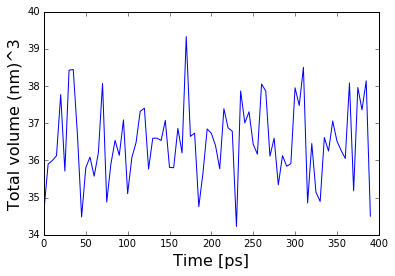

In [115]:
solvent_rad = 0.14
NSamps = 5000
indices = range(0,traj.n_frames,5)
volume = np.zeros(len(indices))
for i in range(len(indices)):
    volume[i] = MonteCarloVolume(traj.xyz[i],NSamps,solvent_rad)
    
plt.plot(indices, volume)
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Total volume (nm)^3', size=16)
plt.show()    

## Comparison of grid-based and Monte Carlo.

 - Running calc_volume with 0.5 Angstrom grid spacing and vdW radius of 1.4 Angstroms.
 - Running MonteCarloVolume with 141\*101\*161 = 2292801, the same number of grid points used in calc_volume.

In [131]:
startTime = datetime.now()

volume = calc_volume(traj.xyz[0],extent=0.14,spacing=0.05)

print "\ncalc_volume completion time = %s seconds" % (datetime.now() - startTime).seconds
print "volume = %.2f nm^3"%volume

initializing grid
Filling sphere
Calculating volume
Grid shape = (141, 101, 161)

calc_volume completion time = 5 seconds
volume = 35.46 nm^3


In [134]:
startTime = datetime.now()

volume = MonteCarloVolume(traj.xyz[0],2292801,0.14)

print "\ncalc_volume completion time = %s seconds" % (datetime.now() - startTime).seconds
print "volume = %.2f nm^3"%volume


calc_volume completion time = 317 seconds
volume = 36.49 nm^3


The grid based method calc_volume is much, much faster! Using it in subsequent analysis.

## Grid based part 2: with numpy's 3D histogram.
No spherical smoothing yet, so histogram only marks atom locations and not the vdW extent of the atom.

In [83]:
nbins = 500
H, edges = np.histogramdd(traj.xyz[0],nbins,normed=False)


In [84]:
print  np.sum(H>=1)*1.0/(nbins**3)

4.24e-05


In [82]:
print np.sum(H>=1)*(edges[0][1]-edges[0][0])*(edges[1][1]-edges[1][0])*(edges[2][1]-edges[2][0])

133.066608911


In [88]:
np.sum(H>=1)*1.0/np.sum(H==0)

4.2401797836228259e-05

In [67]:
(edges[0][1]-edges[0][0])*(edges[1][1]-edges[1][0])*(edges[2][1]-edges[2][0])

0.0014156025

In [68]:
(edges[0][1]-edges[0][0])

0.11280946

In [69]:
(edges[1][1]-edges[1][0])

0.093858838

In [70]:
(edges[2][1]-edges[2][0])

0.13369668

In [103]:
range(10,0,10)

[]

In [105]:
range(0,10,2)

[0, 2, 4, 6, 8]